In [ ]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import itertools

In [2]:
# Load iimages into dictionary given a path
def load_images(path):
    images = {}
    for image_category in os.listdir(path):
        images_per_category = []
        for image in os.listdir(os.path.join(path, image_category)):
            image = cv2.imread(os.path.join(path, image_category, image), 0)
            if image is not None:
                images_per_category.append(image)
        images[image_category] = images_per_category
        
    return images

# Feature extractor, supporting SIFT,SURF and ORB features
def features_extractor(features_type, images):
    descriptors = []
    feature_vectors = {}
    
    if features_type == "sift":
        feature_extractor = cv2.xfeatures2d.SIFT_create()
    
    elif features_type == "orb":
        feature_extractor = cv2.ORB_create()
    
    elif features_type == "surf":
        feature_extractor = cv2.xfeatures2d.SURF_create()
    
    for category, value  in images.items():
        per_class_features = []
        for image in images[category]:
            
            kp, des = feature_extractor.detectAndCompute(image,None)
            descriptors.extend(des)
            per_class_features.append(des)
        
        feature_vectors[category] = per_class_features
    
    return [descriptors, feature_vectors]  

# Kemans clustering over the descriptors
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_
    return visual_words

# Neasrest finding depending on the eculidian distance
def find_index(feature, centres):
    count = 0
    index = 0
    for i in range(len(centres)):
        if(i == 0):
           count = distance.euclidean(feature, centres[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(feature, centres[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                index = i
                count = dist
    return index    

# Build the histograms depending on the Kmeans clusters centres
def build_histograms(feature_vectors, visual_words):
    per_category_histogram = {}
    for key, value in feature_vectors.items():
        histograms = []
        for image_features in value:
            histogram = np.zeros(len(visual_words))
            for feature in image_features:
                nearest_visual_word_index = find_index(feature, visual_words)
                histogram[nearest_visual_word_index] += 1
            histograms.append(histogram)
        per_category_histogram[key] = histograms
    
    return per_category_histogram

# Histograms matching using KNN
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    preds = []
    gts = []
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key

            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
                preds.append(key)
                gts.append(test_key)
            else:
                preds.append(key)
                gts.append(test_key)
    
    
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based, preds, gts]

In [19]:
# Calculates the average accuracy and class based accuracies.  
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))

# Given the confusion matrix, return the precision for a given class
def precision(label, confusion_matrix_input):
    col = confusion_matrix_input[:, label]
    return confusion_matrix_input[label, label] / col.sum()

# Given the confusion matrix, return the recall for a given class
def recall(label, confusion_matrix_input):
    row = confusion_matrix_input[label, :]
    return confusion_matrix_input[label, label] / row.sum()

# Precsion macro average 
def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

# Recall macro average 
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
   

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
images = load_images('./train')  # take all images category by category
test = load_images("./test") # take test images

In [5]:
orbs = features_extractor( "orb", images)

# Takes the descriptor list which is unordered one
descriptor_list = orbs[0]
# Takes the orb features that is seperated class by class for train data
all_bovw_feature = orbs[1]
# Takes the orb features that is seperated class by class for test data
test_bovw_feature = features_extractor("orb", test)[1]

print("features extraction is done!")

features extraion is done!


In [7]:
# Takes the central points which is visual words
visual_words = kmeans(9, descriptor_list)

print("Kmeans is done!")

Kmeans is done!


In [8]:
# Creates histograms for train data
bovw_train = build_histograms(all_bovw_feature, visual_words)
# Creates histograms for test data
bovw_test = build_histograms(test_bovw_feature, visual_words)

print("Building histograms is done!")

Building histograms is done!


In [9]:
# Call the knn function
results_bowl = knn(bovw_train, bovw_test)

print("Knn is done")

In [10]:
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl) 

Average accuracy: %14.344827586206895

Class based accuracies: 

bridge_mid : %11.11111111111111
road_mid : %8.695652173913043
bridge_high : %6.896551724137931
road_low : %16.3265306122449
bridge_low : %21.472392638036812
road_high : %3.9215686274509802
building_low : %19.26605504587156
building_mid : %3.225806451612903
building_high : %14.864864864864865


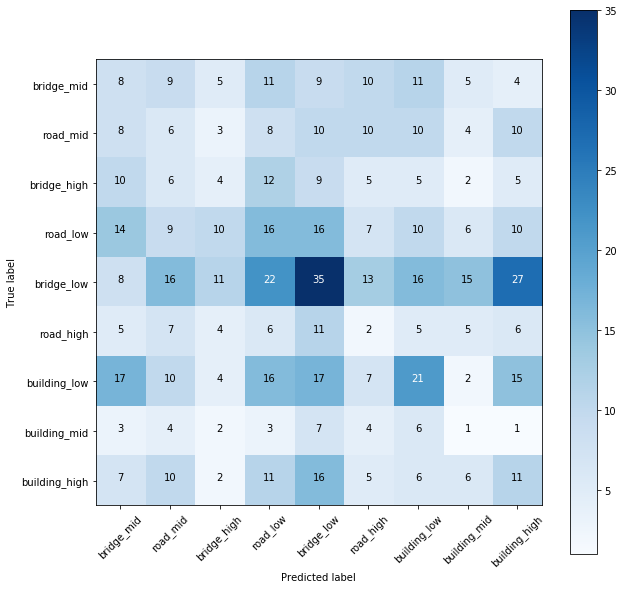

In [23]:
# Creates the confusion matrix
conf_matrix = confusion_matrix(list(results_bowl[4]), list(results_bowl[3]), list(images.keys()))
plt.figure(figsize = (10,10))
plot_confusion_matrix(conf_matrix,classes=list(images.keys()))
plt.savefig("conf_matrix.jpg")

In [ ]:
feature_extractor = cv2.xfeatures2d.SIFT_create()